# CSCE 421 - Machine Learning - Texas A&M University - Spring 2023

# Honors Final Research Project
**Name: Aadith Thiruvallarai**  
**UIN: 230004717**  

## Data Preparation

#### Installing necessary libraries for Google CoLab

In [ ]:
!pip install torch
!pip install torchvision
!pip install torchinfo
!pip install pillow

: 

In [ ]:
# Importing the necessary libraries
import os
from PIL import Image
import torch
import torchvision
from torchvision.utils import make_grid

import numpy as np

: 

We will be using the Pediatric Pneumonia Chest X-ray dataset, provided by LARXEL on Kaggle. Daniel Kermany, Kang Zhang, and Michael Goldbaum accumulated the data (http://dx.doi.org/10.17632/rscbjbr9sj.2). The dataset consists of a training set of 5,856 examples, each example is a grayscale image, associated with a label from 2 classes.  

### Data

The data is split into two directories (pneumonia and normal).
Each image's dimensions are different, so a decision to resize each image to a standard set of dimensions must be done. This will be a potential hyperparameter to consider, because this affects the constructed neural network. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description                |
|-------|----------------------------|
| 0     | Normal                     |
| 1     | Pneumonia                  |

##### File Processing

Checking number of channels
  - grayscale: 1
  - rgb: 3





In [3]:
# # want to check if image is grayscale or color
# # determines if it is one channel or three channels
# def is_gray_scale(img_path):
#     img = Image.open(img_path)
#     imgRGB = img.convert('RGB')
#     w, h = imgRGB.size
#     for i in range(w):
#         for j in range(h):
#             r, g, b = imgRGB.getpixel((i,j))
#             if r != g != b:
#                 return False
#     return True

# # test on four diff images from dataset
# file_path1 = '/content/drive/MyDrive/final-proj-data/IM-0115-0001.jpeg'
# file_path2 = '/content/drive/MyDrive/final-proj-data/person2_bacteria_3.jpeg'
# file_path3 = '/content/drive/MyDrive/final-proj-data/IM-0001-0001.jpeg'
# file_path4 = '/content/drive/MyDrive/final-proj-data/person1_virus_6.jpeg'
# if (is_gray_scale(file_path1)):
#     print('Normal image (115 - 1) is grayscale')
# else:
#     print('Normal image (115 - 1) is color')

# if (is_gray_scale(file_path2)):
#     print('Pneumonia image (person 2 - bacteria 3) is grayscale')
# else:
#     print('Pneumonia image (person 2 - bacteria 3) is color')

# if (is_gray_scale(file_path3)):
#     print('Normal image (1 - 1) is grayscale')
# else:
#     print('Normal image (1 - 1) is color')

# if (is_gray_scale(file_path4)):
#     print('Pneumonia image (person 1 - virus 6) is grayscale')
# else:
#     print('Pneumonia image (person 1 - virus 6) is color')


The previous cell shows that all images are grayscale and that only one input channel will be needed for the first convolutional layer of the neural network!

Tensor transform time!!!

In [3]:
import torchvision.transforms as transforms
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, Grayscale
from torchvision.datasets import ImageFolder

In [4]:
dataset_transform = transforms.Compose([
    ToTensor(),
    Normalize((0.5,),(0.5)),

    # by default uses bilinear interpolation
    # originally resizing to 256
    # may resize to 128
    Resize((256,256)),

    # Grayscale transform in Pytorch takes weighted sum
    # gray pixel = 0.289 * R + 0.587 * G + 0.114 * B
    # coeffcients are standard luminance coeffs for converting to grayscale
    Grayscale(num_output_channels=1)
])

# loading the dataset and apply the transformations
dataset = ImageFolder('/content/drive/MyDrive/dataset/', transform = dataset_transform)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/dataset/'

Data Exploration

In [5]:
print(dataset.classes) # should just list the classes from the table above

NameError: name 'dataset' is not defined

In [7]:
# taken straight from hw6
import matplotlib.pyplot as plt

def show_example(img, label):
    print('Label: {} ({})'.format(dataset.classes[label],label))
    plt.imshow(img.squeeze(), cmap = 'Greys_r')
    plt.axis(False)

Label: normal (0)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


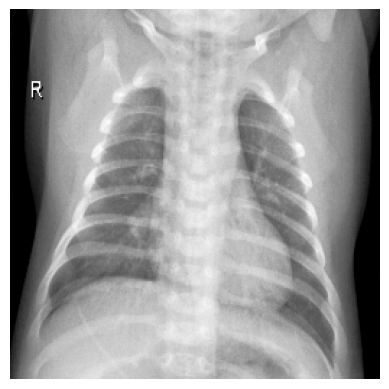

In [8]:
show_example(*dataset[50])

Label: pneumonia (1)


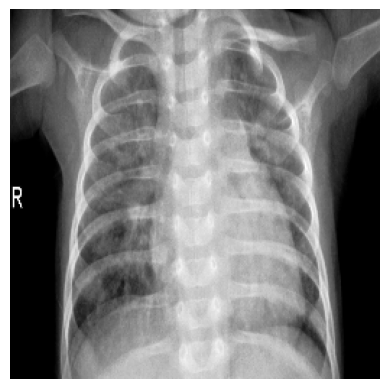

In [9]:
show_example(*dataset[5000])

I noticed in some images that there is text present. I suspect this may skew the neural network to focus on these. Doctors typically look for especially white particulates in the lungs to determine if the patient is suffering from pneumonia, so this is where the concern stems from.

## Creating Training and Validation Datasets

In [10]:
# taken from hw6
def split_indices(n, val_frac, seed):
    n_val = int(val_frac * n)
    np.random.seed(seed)
    indices = np.random.permutation(n)
    return indices[n_val:], indices[:n_val]

In [11]:
## Set the fraction for the validation dataset
val_frac = .20

## Set the random seed (from my birthday)
rand_seed = 6012002

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)

print("# of images in training set: {}".format(len(train_indices)))
print("# of images in validation set: {}".format(len(val_indices)))

# of images in training set: 4685
# of images in validation set: 1171


Now time to use built-in dataloaders in PyTorch! These create iterabes of our training and validation sets. This avoids fitting whole dataset into memory and loads data a batch at the time.

In [12]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

# generally good to keep within range of 16-512
batch_size = 32

In [13]:
#training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size, sampler = train_sampler)

#validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset, batch_size, sampler = val_sampler)

Plotting sample batch of data!

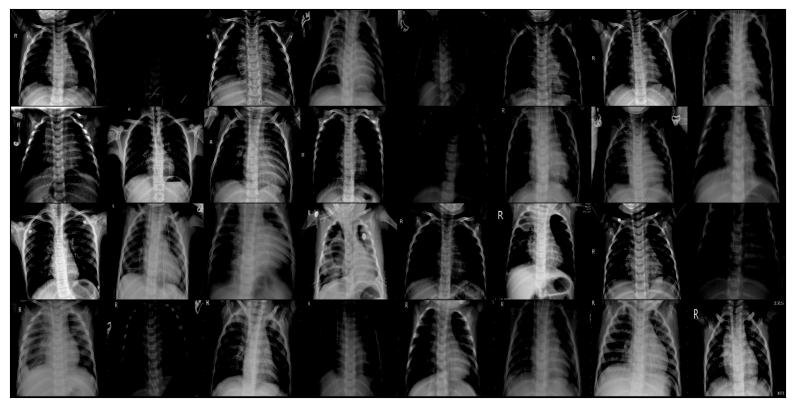

In [14]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0), cmap='Greys_r')
        break

show_batch(train_dl)

## Building the Model

In [15]:
# Import the libraries
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary

This model appears to be overfitting due to a small dataset and being too complex, potentially.

In [16]:
# taken from hw6 and chatgpt for network architecture

class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=3):
        # calling the parent constructor
        super(ImageClassifierNet, self).__init__()

        # initalizing first set of CONV => RELU => POOL layers
        # previously had output channels of 32, 64, 128
        # may change it to 16, 32, 64
        
        # shape - (1, 256, 256)
        self.convLayer1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3)
        self.ReLUFunctionLayer1 = nn.ReLU()
        self.maxPoolLayer1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # shape - (4, 127, 127)
        
        # initalizing second set of CONV => RELU => POOL layers
        self.convLayer2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3)
        self.ReLUFunctionLayer2 = nn.ReLU()
        self.maxPoolLayer2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # shape - (4, 63, 63)

        # initalizing third set of CONV => RELU => POOL layers
        self.convLayer3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3)
        self.ReLUFunctionLayer3 = nn.ReLU()
        self.maxPoolLayer3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        #shape - (4, 30, 30)

        # running into dropout issue
        # self.dropout = nn.Dropout( p = 0.1)
        # self.dropout = nn.Dropout( p = 0.2)
        self.dropout = nn.Dropout( p = 0.3)
        # self.dropout = nn.Dropout( p = 0.4)
        # self.dropout = nn.Dropout( p = 0.5)

        self.flatten = nn.Flatten()

        # intialize fully connected layers
        self.linearLayer4 = nn.Linear(in_features = 128 * 30 * 30, out_features = 1024)
        self.ReLUFunctionLayer4 = nn.ReLU()
        self.linearLayer5 = nn.Linear(in_features = 1024, out_features = 2)
        # self.softMaxFunctionLayer5 = nn.Softmax(dim=1)
        
    def forward(self, x):
        ## Convolution Layers ##
        # pass the input through first set of CONV => RELU => POOL
        x = self.convLayer1(x)
        x = self.ReLUFunctionLayer1(x)
        x = self.maxPoolLayer1(x)

        # pass the input through second set of CONV => RELU => POOL
        x = self.convLayer2(x)
        x = self.ReLUFunctionLayer2(x)
        x = self.maxPoolLayer2(x)

        # pass the input through third set of CONV => RELU => POOL
        x = self.convLayer3(x)
        x = self.ReLUFunctionLayer3(x)
        x = self.maxPoolLayer3(x)
        
        x = self.dropout(x)
        x = self.flatten(x)

        ## Fully Connected Layers ##
        # pass the input through fully connected layer
        x = self.linearLayer4(x)
        x = self.ReLUFunctionLayer4(x)

        # pass softmax function
        x = self.linearLayer5(x)
        # x = self.softMaxFunctionLayer5

        # don't forget to return x lol
        return x

In [17]:
model = ImageClassifierNet()

In [18]:
summary(model, input_size =(batch_size, 1, 256, 256))

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [32, 2]                   --
├─Conv2d: 1-1                            [32, 32, 254, 254]        320
├─ReLU: 1-2                              [32, 32, 254, 254]        --
├─MaxPool2d: 1-3                         [32, 32, 127, 127]        --
├─Conv2d: 1-4                            [32, 64, 125, 125]        18,496
├─ReLU: 1-5                              [32, 64, 125, 125]        --
├─MaxPool2d: 1-6                         [32, 64, 62, 62]          --
├─Conv2d: 1-7                            [32, 128, 60, 60]         73,856
├─ReLU: 1-8                              [32, 128, 60, 60]         --
├─MaxPool2d: 1-9                         [32, 128, 30, 30]         --
├─Dropout: 1-10                          [32, 128, 30, 30]         --
├─Flatten: 1-11                          [32, 115200]              --
├─Linear: 1-12                           [32, 1024]                117,965,8

New less complex model to prevent overfitting

In [38]:
# taken from previous model and slightly modified

class ImageClassifierNet_v2(nn.Module):
    def __init__(self, n_channels=3):
        # calling the parent constructor
        super(ImageClassifierNet_v2, self).__init__()

        # initalizing first set of CONV => RELU => POOL layers
        # previously had output channels of 32, 64, 128
        # may change it to 16, 32, 64
        
        # shape - (1, 256, 256)
        self.convLayer1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3)
        self.ReLUFunctionLayer1 = nn.ReLU()
        self.maxPoolLayer1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # shape - (4, 127, 127)
        
        # initalizing second set of CONV => RELU => POOL layers
        self.convLayer2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3)
        self.ReLUFunctionLayer2 = nn.ReLU()
        self.maxPoolLayer2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # shape - (4, 63, 63)

        ## we will remove the third convolutional layer and see if this simplifies it ##

        # # initalizing third set of CONV => RELU => POOL layers
        # self.convLayer3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3)
        # self.ReLUFunctionLayer3 = nn.ReLU()
        # self.maxPoolLayer3 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        # #shape - (4, 30, 30)

        # running into dropout issue
        # self.dropout = nn.Dropout( p = 0.1)
        # self.dropout = nn.Dropout( p = 0.2)
        # self.dropout = nn.Dropout( p = 0.3)
        # self.dropout = nn.Dropout( p = 0.4)
        self.dropout = nn.Dropout( p = 0.5)

        self.flatten = nn.Flatten()

        # intialize fully connected layers
        self.linearLayer4 = nn.Linear(in_features = 32 * 62 * 62, out_features = 256)
        self.ReLUFunctionLayer4 = nn.ReLU()
        self.linearLayer5 = nn.Linear(in_features = 256, out_features = 2)
        # self.softMaxFunctionLayer5 = nn.Softmax(dim=1)
        
    def forward(self, x):
        ## Convolution Layers ##
        # pass the input through first set of CONV => RELU => POOL
        x = self.convLayer1(x)
        x = self.ReLUFunctionLayer1(x)
        x = self.maxPoolLayer1(x)

        # pass the input through second set of CONV => RELU => POOL
        x = self.convLayer2(x)
        x = self.ReLUFunctionLayer2(x)
        x = self.maxPoolLayer2(x)

        ## removed this layer ##

        # # pass the input through third set of CONV => RELU => POOL
        # x = self.convLayer3(x)
        # x = self.ReLUFunctionLayer3(x)
        # x = self.maxPoolLayer3(x)
        
        x = self.dropout(x)
        x = self.flatten(x)

        ## Fully Connected Layers ##
        # pass the input through fully connected layer
        x = self.linearLayer4(x)
        x = self.ReLUFunctionLayer4(x)

        # pass softmax function
        x = self.linearLayer5(x)
        # x = self.softMaxFunctionLayer5

        # don't forget to return x lol
        return x

In [39]:
# new simpler(?) model

model_v2 = ImageClassifierNet_v2()

In [40]:
# this model has more parameters than the previous one!!!
summary(model_v2, input_size =(batch_size, 1, 256, 256))

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet_v2                    [32, 2]                   --
├─Conv2d: 1-1                            [32, 16, 254, 254]        160
├─ReLU: 1-2                              [32, 16, 254, 254]        --
├─MaxPool2d: 1-3                         [32, 16, 127, 127]        --
├─Conv2d: 1-4                            [32, 32, 125, 125]        4,640
├─ReLU: 1-5                              [32, 32, 125, 125]        --
├─MaxPool2d: 1-6                         [32, 32, 62, 62]          --
├─Dropout: 1-7                           [32, 32, 62, 62]          --
├─Flatten: 1-8                           [32, 123008]              --
├─Linear: 1-9                            [32, 256]                 31,490,304
├─ReLU: 1-10                             [32, 256]                 --
├─Linear: 1-11                           [32, 2]                   514
Total params: 31,495,618
Trainable params: 31,495,618
Non-trainable para

## Enable training on a GPU

**NOTE:** Section is necessary for training model on GPU

In [41]:
#taken from hw6

def get_default_device():
    """Use GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [42]:
device = get_default_device()

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

to_device(model, device)
to_device(model_v2, device)

ImageClassifierNet_v2(
  (convLayer1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (ReLUFunctionLayer1): ReLU()
  (maxPoolLayer1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convLayer2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (ReLUFunctionLayer2): ReLU()
  (maxPoolLayer2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linearLayer4): Linear(in_features=123008, out_features=256, bias=True)
  (ReLUFunctionLayer4): ReLU()
  (linearLayer5): Linear(in_features=256, out_features=2, bias=True)
)

## Training the models!

In [43]:
# taken from hw6

def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
        
    for epoch in range(n_epochs):
        ### training time! ###
        # dropout is given with train() from what i understand
        model.train() # sets model to training mode

        train_loss = 0
        guessed_correct = 0
        n = 0

        #AUC-ROC curve calc variables
        fpr = None
        tpr = None
        thresholds = None
        roc_auc = None

        # y_pred = []
        # y_true = []

        for training_x, actual_training_y in train_dl:
            training_x = training_x.to(device)
            actual_training_y = actual_training_y.to(device)

            ## sets gradients of optimized torch.Tensor to zero ##
            opt_fn.zero_grad()

            ## plug in values ##
            predicted_training_y = model(training_x)

            ## calculate loss w/ loss function and backpropagate ##
            loss = loss_fn(predicted_training_y, actual_training_y)

            # calculating batch loss
            batch_loss = loss.mean()

            # backward pass
            batch_loss.backward()

            # # computes gradients for back pass in network for all w's and b's ##
            # loss.backward()

            # update all w's and b's
            opt_fn.step()

            # item() returns element contained in singleton tensor/numpy array
            train_loss += batch_loss.item()
            
            ## now need to retrieve elements w/ max values in list and their indices ##
            # want to find max for each batch item b/c which is why dim = 1
            batch_item_max_values, batch_item_max_indices = predicted_training_y.max(1)

            # now for total and guessed_correct!
            # .size(0) returns num of elements in first dimension (only 1d)
            # should always be batch size
            n += actual_training_y.size(0)
            guessed_correct += batch_item_max_indices.eq(actual_training_y).sum().item()

            #batch_loss = loss.mean()
            #batch_loss.backward()
            # optimizer.step()

        train_losses.append(train_loss / len(train_dl))
        train_accuracy = guessed_correct / n
        train_accuracies.append(train_accuracy)

        # Validation process
        val_loss = 0
        val_accuracy = None
        n = 0 # reset for val_accuracy
        guessed_correct = 0
        # train_loss = 0
        if len(val_dl) != 0:
            val_accuracy = 0
            # eval time!
            # set model to evaluation
            model.eval()
            with torch.no_grad():
                for validation_x, actual_validation_y in val_dl:
                    validation_x = validation_x.to(device)
                    actual_validation_y = actual_validation_y.to(device)

                    predicted_validation_y = model(validation_x)

                    # ## AUC-ROC curve calculations ##
                    # y_scores = torch.sigmoid(predicted_validation_y.cpu()).detach().numpy()
                    # y_true = actual_validation_y.cpu().numpy()

                    # fpr, tpr, thresholds = roc_curve(y_true, y_scores)
                    # roc_auc = auc(fpr, tpr) 


                    loss = loss_fn(predicted_validation_y,actual_validation_y)

                    batch_loss = loss.mean()

                    val_loss += batch_loss.item()

                    batch_item_max_values, batch_item_max_indices = predicted_validation_y.max(1)
                    
                    guessed_correct += batch_item_max_indices.eq(actual_validation_y).sum().item()
                    n += actual_validation_y.size(0)
            
            val_losses.append(val_loss / len(val_dl))
            val_accuracy = guessed_correct / n
            val_accuracies.append(val_accuracy)
    
        # Print progress
        # changed .4f to .10f b/c model trained on dataset didn't change accuracy w/ four decimal places
        if val_accuracy is not None:
            print("Epoch {}/{}, train_loss: {:.10f}, val_loss: {:.10f}, train_accuracy: {:.10f}, val_accuracy: {:.10f}"
                  .format(epoch+1, n_epochs, train_loss, val_loss, train_accuracy, val_accuracy))
        else:
            print("Epoch {}/{}, train_loss: {:.10f}, train_accuracy: {:.10f}"
                  .format(epoch+1, n_epochs, train_loss, train_accuracy))
        # # Plot ROC curve
        # plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        # plt.plot([0, 1], [0, 1], 'k--')
        # plt.xlabel('False Positive Rate')
        # plt.ylabel('True Positive Rate')
        # plt.title('Receiver Operating Characteristic (ROC) Curve')
        # plt.legend(loc="lower right")
        # plt.show()
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [44]:
# max number of training epochs
num_epochs = 5

# defining the loss function (cross entropy for classification problem)
loss_fn = nn.CrossEntropyLoss()

# setting the learning rate
learning_rate = 0.001

# selecting an optimizer (Adam/SGD?)
#opt_fn = torch.optim.SGD(model.parameters(), lr = lr, momentum = 0.9)
opt_fn = torch.optim.Adam(model_v2.parameters(), lr = learning_rate)

In [45]:
# New Model
history = train_model(num_epochs, model_v2, train_dl, val_dl, loss_fn, opt_fn, learning_rate)
model_v2, train_losses, val_losses, train_accuracies, val_accuracies = history

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1/5, train_loss: 58.8795599341, val_loss: 6.0858710706, train_accuracy: 0.8557097118, val_accuracy: 0.9402220325
Epoch 2/5, train_loss: 20.1400465835, val_loss: 5.1809864659, train_accuracy: 0.9502668090, val_accuracy: 0.9521776260
Epoch 3/5, train_loss: 17.2861511605, val_loss: 5.1165147293, train_accuracy: 0.9560298826, val_accuracy: 0.9538855679
Epoch 4/5, train_loss: 14.4516147119, val_loss: 4.9038909711, train_accuracy: 0.9628601921, val_accuracy: 0.9530315969
Epoch 5/5, train_loss: 13.0466297101, val_loss: 4.8041566918, train_accuracy: 0.9690501601, val_accuracy: 0.9547395389


## Plot loss and accuracy

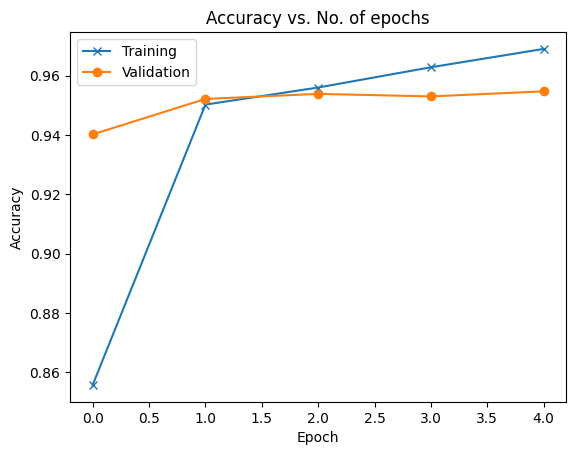

In [46]:
# taken from hw6
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

plot_accuracy(train_accuracies, val_accuracies)

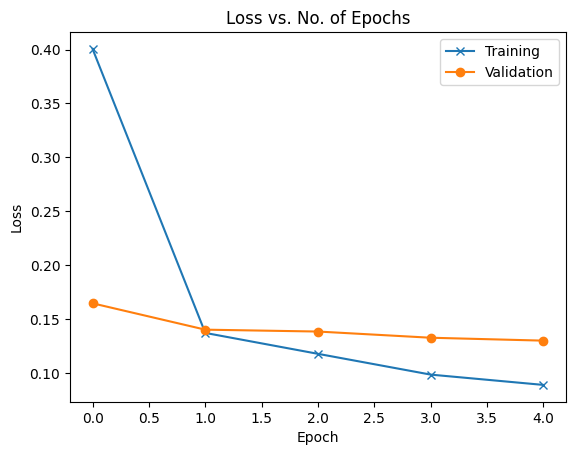

In [47]:
# taken from hw6
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

plot_losses(train_losses, val_losses)

In [48]:

# torch.save(model.state_dict(), '/content/drive/MyDrive/dataset/model.pt')

In [49]:
# torch.save(model_v2.state_dict(), '/content/drive/MyDrive/model_v2.pt')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


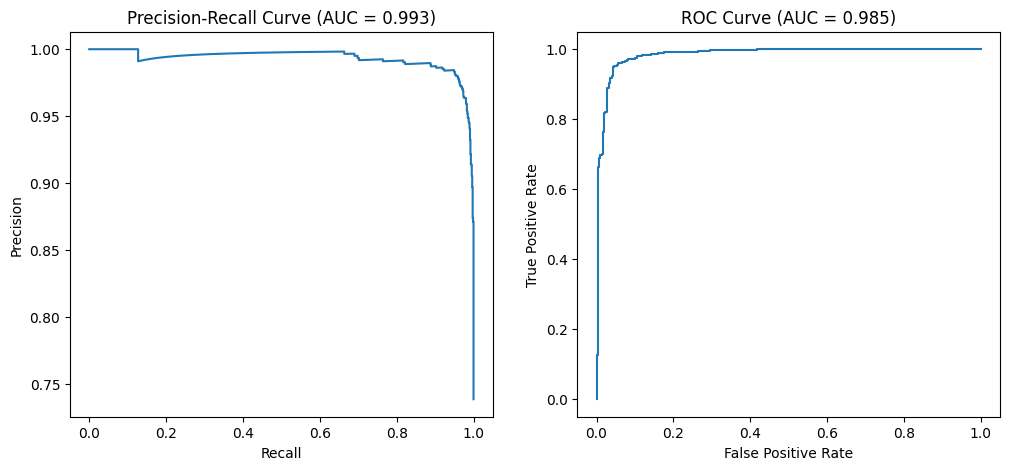

In [51]:
# credit to chatgpt

from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Load the model and test data
# model_v2 = torch.load('/content/drive/MyDrive/model_v2.pt')
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

# Set the device to GPU if available
# model_v2.to(device)
# to_device(model_v2, device)

# Set the model to evaluation mode
model_v2.eval()

# Predict the output for the test data
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in val_dl:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_v2(inputs)
        y_pred.append(outputs.cpu().numpy())
        y_true.append(labels.cpu().numpy())
y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

y_true = y_true.flatten()

# Calculate the precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_pred[:,1])
prc_auc = auc(recall, precision)

# Calculate fpr, tpr, and roc-auc
fpr, tpr, _ = roc_curve(y_true, y_pred[:,1])
roc_auc = auc(fpr,tpr)

# Plot the precision-recall and AUC-ROC curve
fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].plot(recall, precision)
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve (AUC = {:.3f})'.format(prc_auc))

ax[1].plot(fpr, tpr)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve (AUC = {:.3f})'.format(roc_auc))
plt.show()

In [52]:
torch.save(model_v2.state_dict(), '/content/drive/MyDrive/model_v2.pt')